# preferable do the following in a virtual environment as tensorflow needs to be downgraded to v1 to be compatible with sagemaker

In [ ]:
!pip install tensorflow==1.15.5

In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
#from keras.models import Sequential
#from keras import models, layers
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, GRU, Bidirectional

In [2]:
#make sure the tensorflow version using is 1.15.5
tf.__version__

'1.15.5'

In [3]:
dataset_p1 = 'keypoint_part1.csv'
dataset_p2 = 'keypoint_part2.csv'
dataset_p3 = 'keypoint_part3.csv'
dataset_p4 = 'data.csv'
model_save_path = 'sampleModel'

In [4]:
'''
#shuffle data
import pandas as pd
df = pd.read_csv(dataset_p4, header=None)
ds = df.sample(frac=1)
ds.to_csv(dataset_p4)
'''

'\n#shuffle data\nimport pandas as pd\ndf = pd.read_csv(dataset_p4, header=None)\nds = df.sample(frac=1)\nds.to_csv(dataset_p4)\n'

In [5]:
NUM_CLASSES = 29
RANDOM_SEED = 42

In [6]:
X_dataset1 = np.loadtxt(dataset_p1, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset1 = np.loadtxt(dataset_p1, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_dataset2 = np.loadtxt(dataset_p2, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset2 = np.loadtxt(dataset_p2, delimiter=',', dtype='int32', usecols=(0))
y_dataset2 = y_dataset2+10

In [8]:
X_dataset3 = np.loadtxt(dataset_p3, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset3 = np.loadtxt(dataset_p3, delimiter=',', dtype='int32', usecols=(0))
y_dataset3 = y_dataset3+20

In [9]:
X_dataset4 = np.loadtxt(dataset_p4, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset4 = np.loadtxt(dataset_p4, delimiter=',', dtype='int32', usecols=(0))

In [10]:
concat_x = np.concatenate((X_dataset1,X_dataset2),axis=0)
concat_x = np.concatenate((concat_x,X_dataset3),axis=0)
concat_x = np.concatenate((concat_x,X_dataset4),axis=0)

In [11]:
concat_y = np.concatenate((y_dataset1,y_dataset2),axis=0)
concat_y = np.concatenate((concat_y,y_dataset3),axis=0)
concat_y = np.concatenate((concat_y,y_dataset4),axis=0)
print(concat_y.shape)

(70789,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(concat_x, concat_y, train_size=0.75, random_state=RANDOM_SEED)

In [13]:
concat_x.shape

(70789, 42)

In [14]:
### Validation data
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(X_train
                                                                              ,y_train
                                                                              ,test_size=.2
                                                                              ,random_state=RANDOM_SEED
                                                                              ,shuffle=True)

In [35]:
###a adding timestep to makesure convo1D in TF 1.15.5 version works
time_steps = 5
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(42,), name="input"))
model.add(tf.keras.layers.RepeatVector(time_steps))

## adding convolutional layers
model.add(tf.keras.layers.Conv1D(256, 5,1, activation="relu", padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.001) ))
model.add(tf.keras.layers.MaxPool1D(1,strides=2))
model.add(tf.keras.layers.Dropout(.20))
model.add(tf.keras.layers.Conv1D(128, 3,1, activation="relu", padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPool1D(1,strides=2))
model.add(tf.keras.layers.Dropout(.20))
model.add(tf.keras.layers.Conv1D(64, 3,1, activation="relu", padding="same",kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.MaxPool1D(1,strides=2))
model.add(tf.keras.layers.Dropout(.20))

## adding Bidirectional LSTMlayers
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
model.add(tf.keras.layers.Dropout(.20))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
model.add(tf.keras.layers.Dropout(.20))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)))
model.add(tf.keras.layers.Dropout(.20))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=256, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(units=50, activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.nn.softmax))
model.build()

In [36]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_2 (RepeatVecto (None, 5, 42)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 256)            54016     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 256)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 128)            98432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 128)           

In [37]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

In [38]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
#import numpy as np
#series_input_train = np.expand_dims(X_train, axis=-1)

In [40]:
#best model 9.1Mb : loss: 0.3844 - accuracy: 0.8755 - val_loss: 0.3243 - val_accuracy: 0.8951 
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=512,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback,tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)]
)

Train on 53091 samples, validate on 17698 samples
Epoch 1/1000
52736/53091 [============================>.] - ETA: 0s - loss: 2.4214 - acc: 0.3234
Epoch 00001: saving model to sampleModel
53091/53091 [==============================] - 15s 289us/sample - loss: 2.4153 - acc: 0.3252 - val_loss: 2.6745 - val_acc: 0.6334
Epoch 2/1000
52736/53091 [============================>.] - ETA: 0s - loss: 1.0596 - acc: 0.7515
Epoch 00002: saving model to sampleModel
53091/53091 [==============================] - 9s 167us/sample - loss: 1.0580 - acc: 0.7521 - val_loss: 1.8307 - val_acc: 0.8427
Epoch 3/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.7794 - acc: 0.8462
Epoch 00003: saving model to sampleModel
53091/53091 [==============================] - 8s 158us/sample - loss: 0.7787 - acc: 0.8464 - val_loss: 1.1293 - val_acc: 0.8991
Epoch 4/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.6707 - acc: 0.8735
Epoch 00004: saving model to sampleModel
53091/5309

Epoch 32/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.3341 - acc: 0.9377
Epoch 00032: saving model to sampleModel
53091/53091 [==============================] - 8s 151us/sample - loss: 0.3338 - acc: 0.9377 - val_loss: 0.3026 - val_acc: 0.9483
Epoch 33/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.3390 - acc: 0.9361
Epoch 00033: saving model to sampleModel
53091/53091 [==============================] - 8s 157us/sample - loss: 0.3390 - acc: 0.9361 - val_loss: 0.2932 - val_acc: 0.9490
Epoch 34/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.3313 - acc: 0.9380
Epoch 00034: saving model to sampleModel
53091/53091 [==============================] - 10s 193us/sample - loss: 0.3315 - acc: 0.9380 - val_loss: 0.3225 - val_acc: 0.9434
Epoch 35/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.3240 - acc: 0.9411
Epoch 00035: saving model to sampleModel
53091/53091 [==============================] - 9s 174us/

Epoch 63/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.2934 - acc: 0.9444
Epoch 00063: saving model to sampleModel
53091/53091 [==============================] - 8s 152us/sample - loss: 0.2935 - acc: 0.9444 - val_loss: 0.2604 - val_acc: 0.9576
Epoch 64/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.2886 - acc: 0.9457
Epoch 00064: saving model to sampleModel
53091/53091 [==============================] - 9s 161us/sample - loss: 0.2888 - acc: 0.9457 - val_loss: 0.2653 - val_acc: 0.9543
Epoch 65/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.2954 - acc: 0.9452
Epoch 00065: saving model to sampleModel
53091/53091 [==============================] - 8s 158us/sample - loss: 0.2955 - acc: 0.9452 - val_loss: 0.2707 - val_acc: 0.9552
Epoch 66/1000
52736/53091 [============================>.] - ETA: 0s - loss: 0.2941 - acc: 0.9441
Epoch 00066: saving model to sampleModel
53091/53091 [==============================] - 8s 151us/s

In [41]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=512)

17698/17698 [==============================] - 1s 45us/sample - loss: 0.2568 - acc: 0.9564


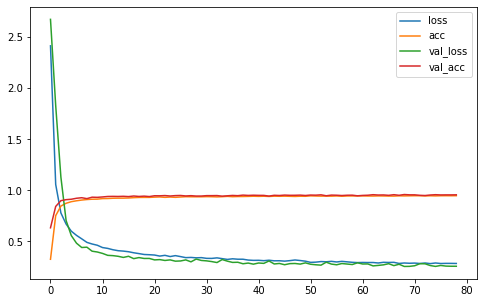

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

# Save Model

In [43]:
model.save(model_save_path, include_optimizer=False)

# Visualize

In [44]:
model = tf.keras.models.load_model(model_save_path)
predict_result = model.predict(np.array([X_test[0]]))
#print(np.squeeze(predict_result))
#print(np.argmax(np.squeeze(predict_result)))

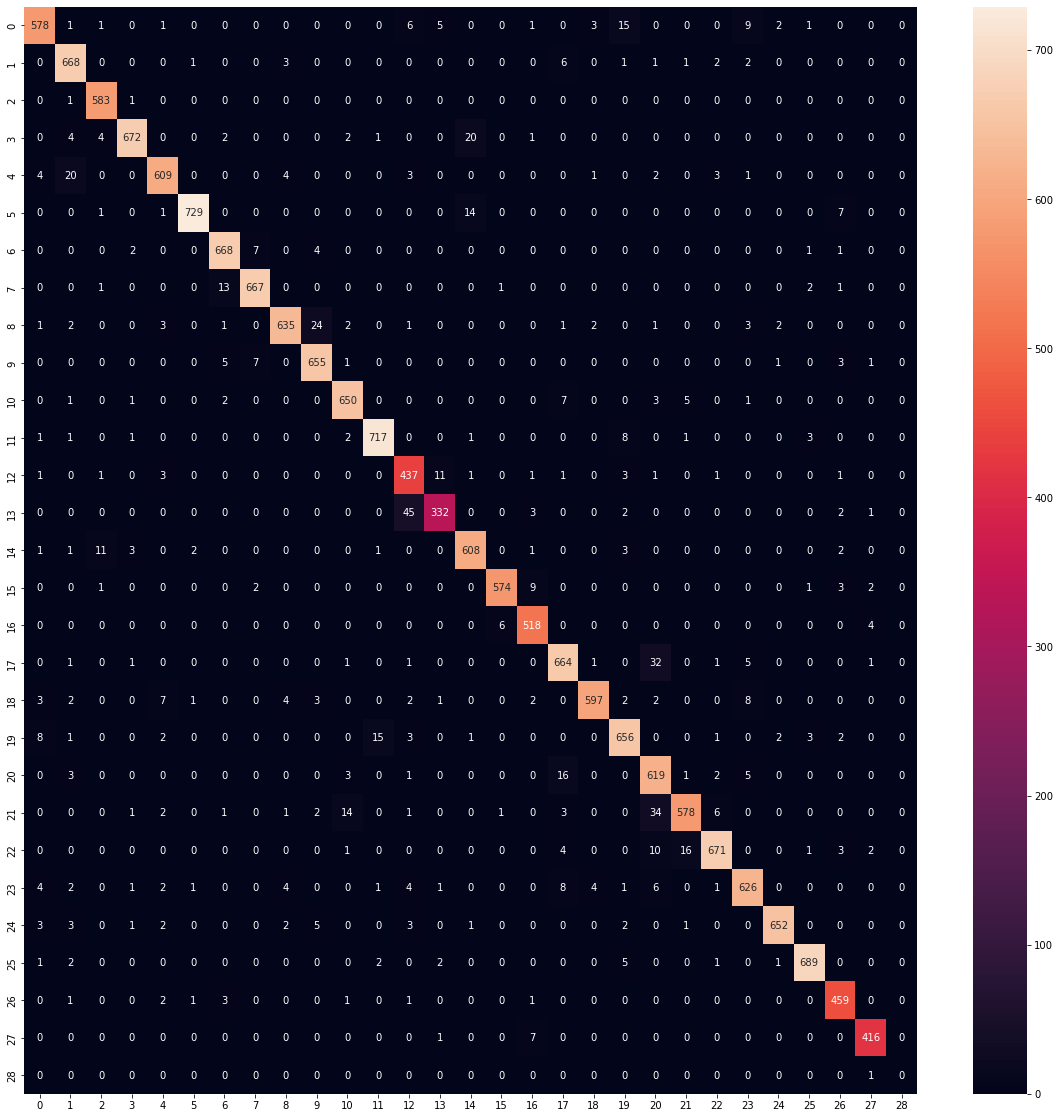

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       623
           1       0.94      0.98      0.95       685
           2       0.97      1.00      0.98       585
           3       0.98      0.95      0.97       706
           4       0.96      0.94      0.95       647
           5       0.99      0.97      0.98       752
           6       0.96      0.98      0.97       683
           7       0.98      0.97      0.98       685
           8       0.97      0.94      0.95       678
           9       0.95      0.97      0.96       673
          10       0.96      0.97      0.97       670
          11       0.97      0.98      0.97       735
          12       0.86      0.95      0.90       462
          13       0.94      0.86      0.90       385
          14       0.94      0.96      0.95       633
          15       0.99      0.97      0.98       592
          16       0.95      0.98      0.97       528
     

/Users/pranav/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranav/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranav/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)